In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from keras.applications import MobileNetV2, ResNet50, EfficientNetB0, InceptionV3, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import os

2024-12-30 08:33:31.600889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-30 08:33:31.705446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735527811.747801   13794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735527811.760228   13794 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 08:33:31.860817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

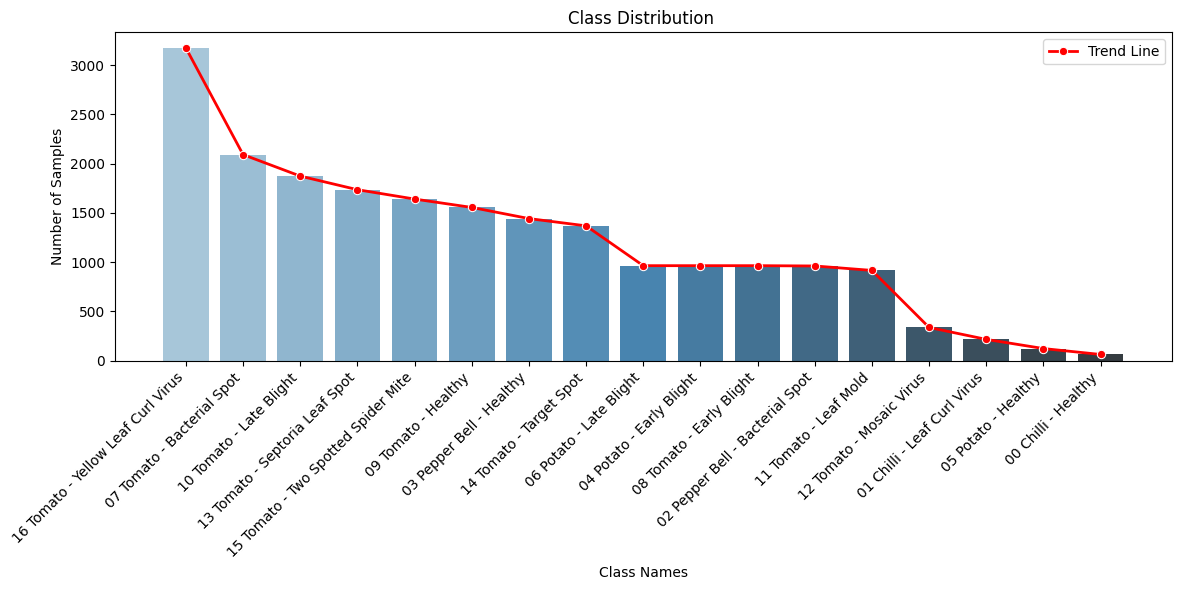

In [2]:
def plot_class_distribution(data_dir):
    class_counts = {}

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    classes, counts = zip(*sorted_classes)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(classes), y=list(counts), palette="Blues_d", hue=list(classes))
    sns.lineplot(x=range(len(classes)), y=list(counts), color='red', marker='o', linewidth=2, label='Trend Line')

    plt.title('Class Distribution ')
    plt.xlabel('Class Names')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_class_distribution('./PlantVillage/train')


In [3]:
def get_preprocessing_function(base_model_name):
    if base_model_name == 'MobileNetV2':
        return mobilenet_preprocess
    elif base_model_name == 'ResNet50':
        return resnet_preprocess
    elif base_model_name == 'EfficientNetB0':
        return efficientnet_preprocess
    elif base_model_name == 'InceptionV3':
        return inception_preprocess
    elif base_model_name == 'DenseNet121':
        return densenet_preprocess
    else:
        raise ValueError("Unsupported model: " + base_model_name)

In [4]:



def train_model(
    base_model_name='MobileNetV2',  # Base model to use
    train_dir='./train',  # Path to training dataset
    test_dir='./test',  # Path to testing dataset
    model_save_name='best_model.keras',  # File name to save the best model
    image_size=(224, 224),  # Image size to resize
    batch_size=32,  # Batch size for training
    validation_split=0.2,  # Validation split
    epochs=10,  # Number of epochs
    learning_rate=0.001,  # Learning rate
    patience=5  # Patience for early stopping
):

    train_dataset = image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        validation_split=validation_split,
        subset="training",
        seed=123
    )
    class_names = train_dataset.class_names

    validation_dataset = image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        validation_split=validation_split,
        subset="validation",
        seed=123
    )

    test_dataset = image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=batch_size
    )

    preprocess_fn = get_preprocessing_function(base_model_name)

    def preprocess_image(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = preprocess_fn(image)
        return image, label


    train_dataset = train_dataset.map(preprocess_image).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(preprocess_image).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(preprocess_image).prefetch(buffer_size=tf.data.AUTOTUNE)

    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    else:
        raise ValueError("Unsupported model: " + base_model_name)

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')  # Adjust for number of classes
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_save_name,
        monitor='val_loss',
        save_best_only=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce the learning rate by 0.5
        patience=2,  # Wait epochs before reducing learning rate
        min_lr=1e-5  # Minimum learning rate
    )

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler]
    )

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)``
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Found 20401 files belonging to 17 classes.
Using 16321 files for training.


I0000 00:00:1735527817.034415   13794 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 20401 files belonging to 17 classes.
Using 4080 files for validation.
Found 576 files belonging to 17 classes.
Epoch 1/40


I0000 00:00:1735527822.087861   13950 service.cc:148] XLA service 0x7559140027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735527822.088532   13950 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-30 08:33:42.433054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735527822.838739   13950 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-30 08:33:43.446658: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6681', 60 bytes spill stores, 64 bytes spill loads

2024-12-30 08:33:43.447816: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4365

  7/511 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.1869 - loss: 3.0747

I0000 00:00:1735527827.673937   13950 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.5744 - loss: 1.4032 - val_accuracy: 0.8775 - val_loss: 0.3964 - learning_rate: 0.0010
Epoch 2/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8125 - loss: 0.5702 - val_accuracy: 0.9042 - val_loss: 0.2994 - learning_rate: 0.0010
Epoch 3/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8577 - loss: 0.4337 - val_accuracy: 0.9091 - val_loss: 0.2695 - learning_rate: 0.0010
Epoch 4/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8778 - loss: 0.3707 - val_accuracy: 0.9203 - val_loss: 0.2488 - learning_rate: 0.0010
Epoch 5/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8828 - loss: 0.3452 - val_accuracy: 0.9255 - val_loss: 0.2248 - learning_rate: 0.0010
Epoch 6/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8983 - loss: 0.3069 - val_accuracy: 0.9221 - val_loss: 0.2340 - learning_rate: 0.0010
Epoch 7/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9002 - loss: 0.2969

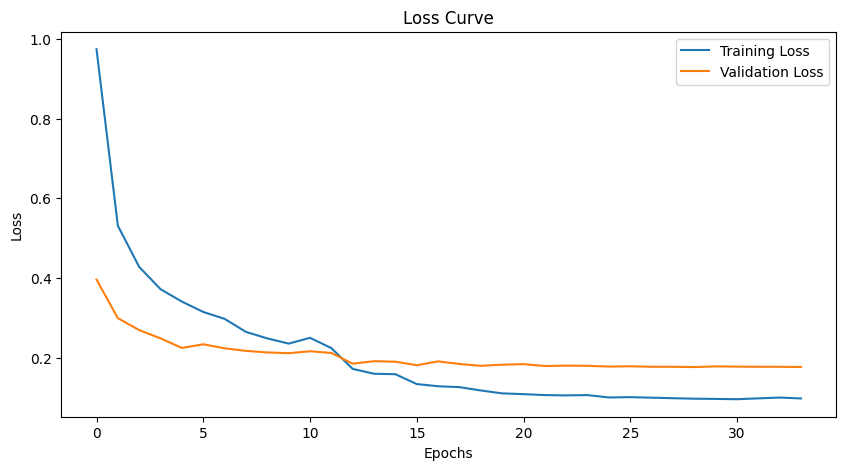

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9274 - loss: 0.2707
Test Accuracy: 91.84%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Classification Report:
                                     precision    recall  f1-score   support

                00 Chilli - Healthy       1.00      0.52      0.69        23
        01 Chilli - Leaf Curl Virus       0.

2024-12-30 08:41:35.911793: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


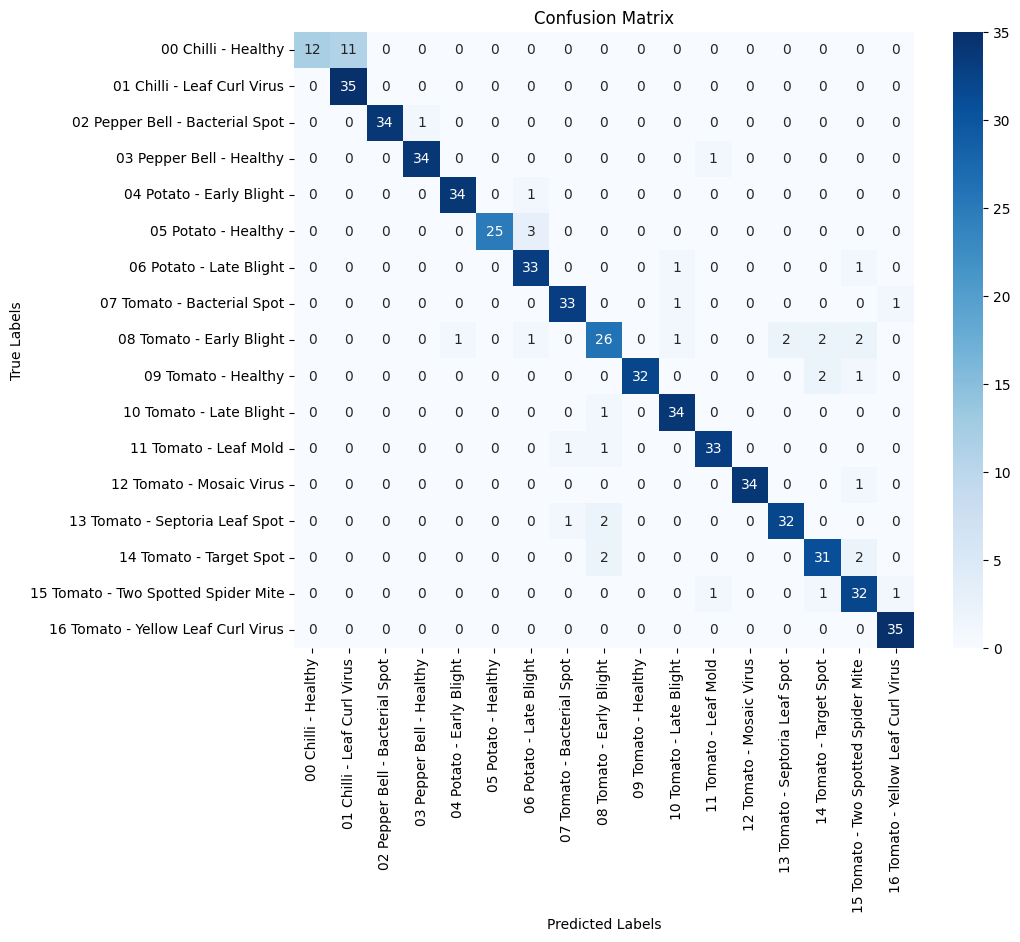

In [5]:
train_model(
    base_model_name='MobileNetV2',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/test',
    model_save_name='best_mnv2_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.001,
    patience=5
)

Found 20401 files belonging to 17 classes.
Using 16321 files for training.
Found 20401 files belonging to 17 classes.
Using 4080 files for validation.
Found 576 files belonging to 17 classes.
Epoch 1/40


2024-12-30 08:41:43.499172: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5284_0', 112 bytes spill stores, 224 bytes spill loads

2024-12-30 08:41:43.636954: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5284', 220 bytes spill stores, 576 bytes spill loads

2024-12-30 08:41:43.708259: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8147', 24 bytes spill stores, 24 bytes spill loads

2024-12-30 08:41:43.710236: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8147', 60 bytes spill stores, 64 bytes spill loads



511/511 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.5810 - loss: 1.3826 - val_accuracy: 0.8750 - val_loss: 0.4014 - learning_rate: 0.0050
Epoch 2/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.7328 - loss: 0.7786 - val_accuracy: 0.9056 - val_loss: 0.2993 - learning_rate: 0.0050
Epoch 3/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.7356 - loss: 0.7534 - val_accuracy: 0.9174 - val_loss: 0.2621 - learning_rate: 0.0050
Epoch 4/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7706 - loss: 0.6526 - val_accuracy: 0.9221 - val_loss: 0.2422 - learning_rate: 0.0050
Epoch 5/40
510/511 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7759 - loss: 0.6457

2024-12-30 08:44:35.123167: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7759 - loss: 0.6457 - val_accuracy: 0.9333 - val_loss: 0.2201 - learning_rate: 0.0050
Epoch 6/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.7913 - loss: 0.5807 - val_accuracy: 0.9441 - val_loss: 0.1893 - learning_rate: 0.0050
Epoch 7/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8134 - loss: 0.5335 - val_accuracy: 0.9324 - val_loss: 0.2090 - learning_rate: 0.0050
Epoch 8/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8086 - loss: 0.5415 - val_accuracy: 0.9402 - val_loss: 0.2180 - learning_rate: 0.0050
Epoch 9/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8464 - loss: 0.4298 - val_accuracy: 0.9593 - val_loss: 0.1396 - learning_rate: 0.0025
Epoch 10/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.8660 - loss: 0.3724 - val_accuracy: 0.9559 - val_loss: 0.1480 - learning_rate: 0.0025
Epoch 11/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.8700 - loss: 0.36

2024-12-30 09:04:36.012253: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9146 - loss: 0.2300 - val_accuracy: 0.9748 - val_loss: 0.1046 - learning_rate: 3.9062e-05
Epoch 34/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9140 - loss: 0.2334 - val_accuracy: 0.9755 - val_loss: 0.1037 - learning_rate: 3.9062e-05
Epoch 35/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - accuracy: 0.9165 - loss: 0.2257 - val_accuracy: 0.9752 - val_loss: 0.1036 - learning_rate: 1.9531e-05
Epoch 36/40


2024-12-30 09:06:57.196984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 144s 280ms/step - accuracy: 0.9158 - loss: 0.2228 - val_accuracy: 0.9743 - val_loss: 0.1037 - learning_rate: 1.9531e-05
Epoch 37/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9157 - loss: 0.2275 - val_accuracy: 0.9745 - val_loss: 0.1033 - learning_rate: 1.0000e-05
Epoch 38/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9087 - loss: 0.2376 - val_accuracy: 0.9748 - val_loss: 0.1031 - learning_rate: 1.0000e-05


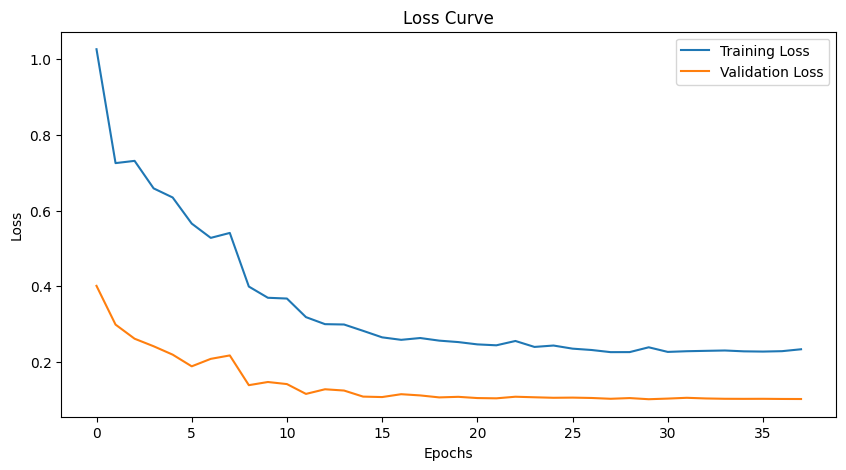

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9420 - loss: 0.1609
Test Accuracy: 94.27%
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Classification Report:
                                     precision    recall  f1-score   support

                00 Chilli - Healthy       1.00      0.52      0.69        23
        01 Chilli - Leaf Curl Virus       0.

2024-12-30 09:10:48.997006: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


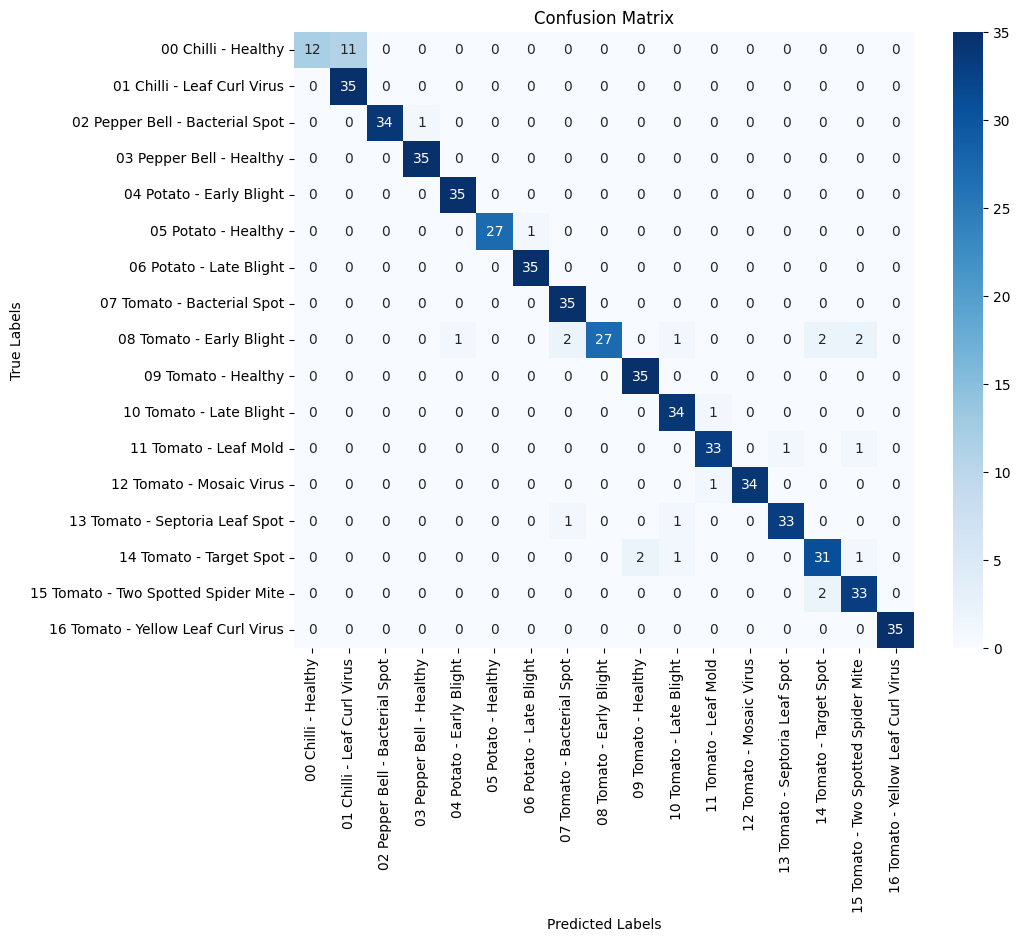

In [6]:
train_model(
    base_model_name='ResNet50',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/test',
    model_save_name='best_rn50_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    patience=8
)

Found 20401 files belonging to 17 classes.
Using 16321 files for training.
Found 20401 files belonging to 17 classes.
Using 4080 files for validation.
Found 576 files belonging to 17 classes.
Epoch 1/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.6305 - loss: 1.1561 - val_accuracy: 0.8990 - val_loss: 0.2921 - learning_rate: 0.0050
Epoch 2/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8077 - loss: 0.5763 - val_accuracy: 0.9238 - val_loss: 0.2092 - learning_rate: 0.0050
Epoch 3/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8444 - loss: 0.4604 - val_accuracy: 0.9363 - val_loss: 0.1744 - learning_rate: 0.0050
Epoch 4/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8662 - loss: 0.3910 - val_accuracy: 0.9328 - val_loss: 0.2008 - learning_rate: 0.0050
Epoch 5/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8653 - loss: 0.4054 - val_accuracy: 0.9326 - val_loss: 0.1936 - learning_rate: 0.0050
Epoch 6/40
511/511 ━━━━━━━━━━━━━━━━━━━

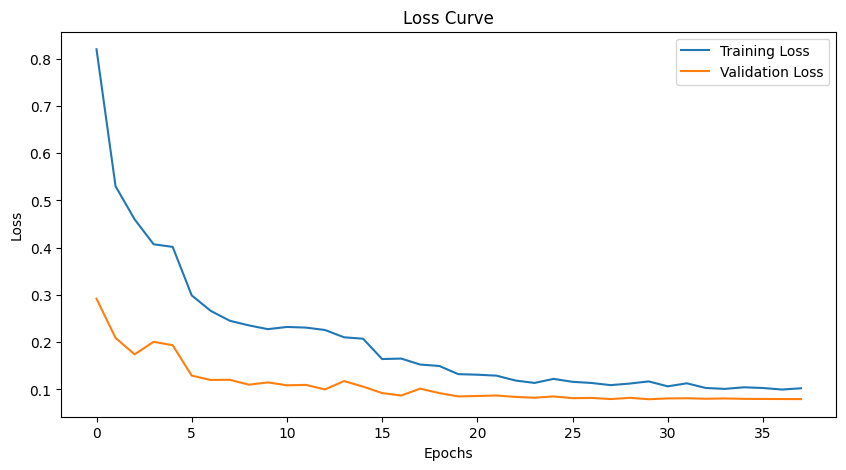

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9607 - loss: 0.1476
Test Accuracy: 96.18%
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Classification Report:
                                     precision    recall  f1-score   support

                00 Chilli - Healthy       1.00      0.70      0.82        23
        01 Chilli - Leaf Curl Virus       0.

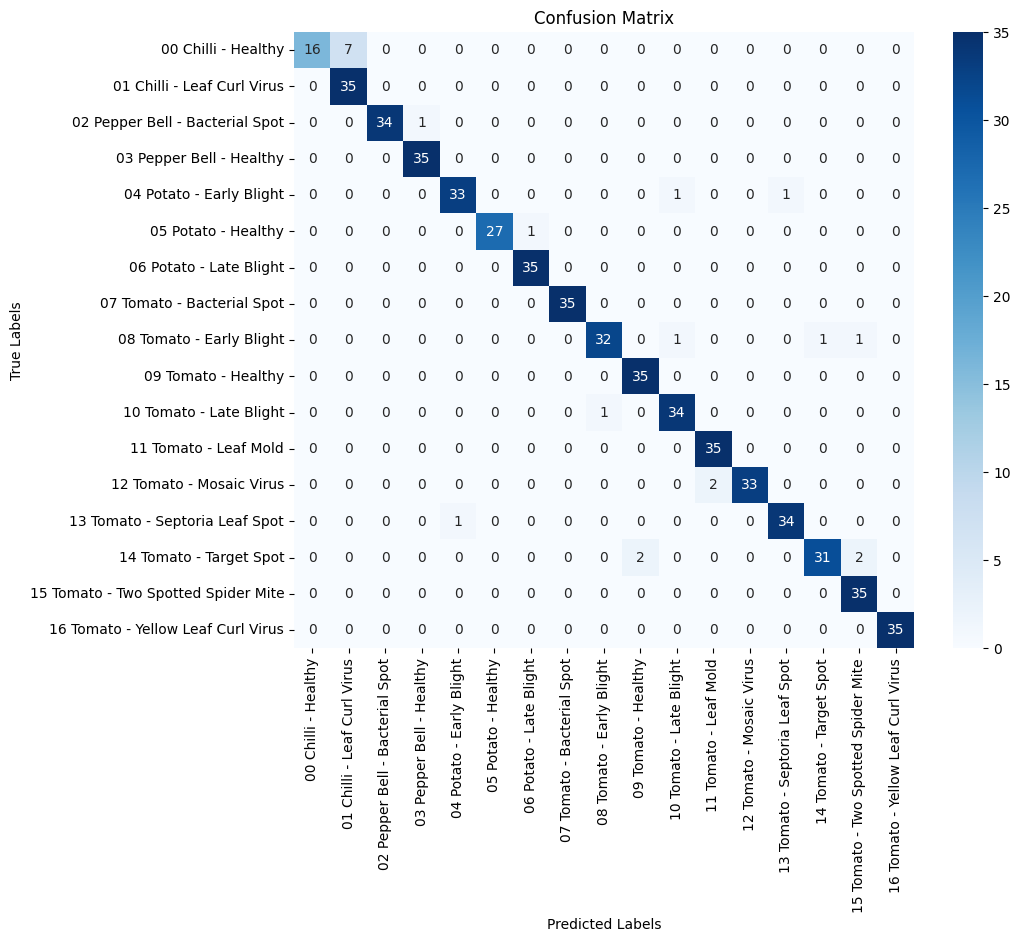

In [7]:


train_model(
    base_model_name='EfficientNetB0',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/test',
    model_save_name='best_en_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    patience=8
)

Found 20401 files belonging to 17 classes.
Using 16321 files for training.
Found 20401 files belonging to 17 classes.
Using 4080 files for validation.
Found 576 files belonging to 17 classes.
Epoch 1/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.4462 - loss: 1.7869 - val_accuracy: 0.7483 - val_loss: 0.7705 - learning_rate: 0.0010
Epoch 2/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.6759 - loss: 0.9923 - val_accuracy: 0.7919 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 3/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.6959 - loss: 0.9069 - val_accuracy: 0.8115 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 4/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.7141 - loss: 0.8398 - val_accuracy: 0.8250 - val_loss: 0.5289 - learning_rate: 0.0010
Epoch 5/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.7357 - loss: 0.7794 - val_accuracy: 0.8382 - val_loss: 0.5012 - learning_rate: 0.0010
Epoch 6/40
511/511 ━━━━━━━━━━━━━━━━━━━

2024-12-30 10:00:06.469156: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.7529 - loss: 0.7275 - val_accuracy: 0.8404 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 7/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.7654 - loss: 0.6953 - val_accuracy: 0.8434 - val_loss: 0.4557 - learning_rate: 0.0010
Epoch 8/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.7702 - loss: 0.6631 - val_accuracy: 0.8551 - val_loss: 0.4315 - learning_rate: 0.0010
Epoch 9/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7749 - loss: 0.6315 - val_accuracy: 0.8608 - val_loss: 0.4321 - learning_rate: 0.0010
Epoch 10/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.7852 - loss: 0.6131 - val_accuracy: 0.8600 - val_loss: 0.4286 - learning_rate: 0.0010
Epoch 11/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.7952 - loss: 0.5916 - val_accuracy: 0.8488 - val_loss: 0.4437 - learning_rate: 0.0010
Epoch 12/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.7895 - loss: 0.6

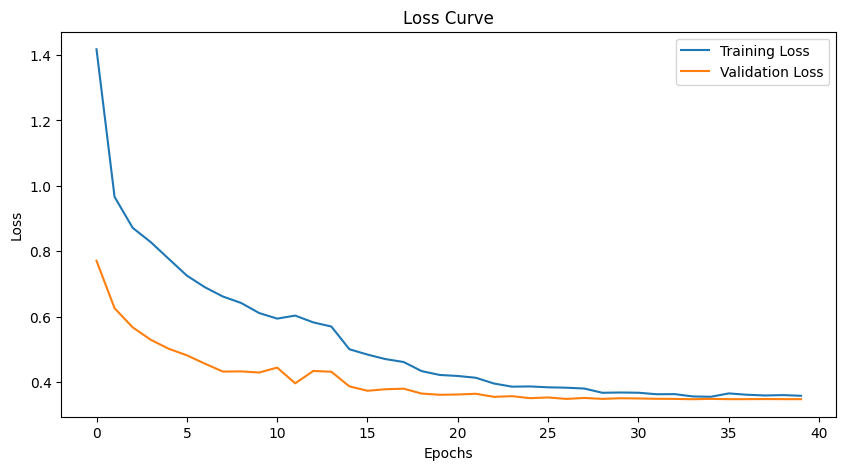

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8444 - loss: 0.4760
Test Accuracy: 85.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Classification Report:
                                     precision    recall  f1-score   support

                00 Chilli - Healthy       1.00      0.43      0.61        23
        01 Chilli - Leaf Curl Virus       0.

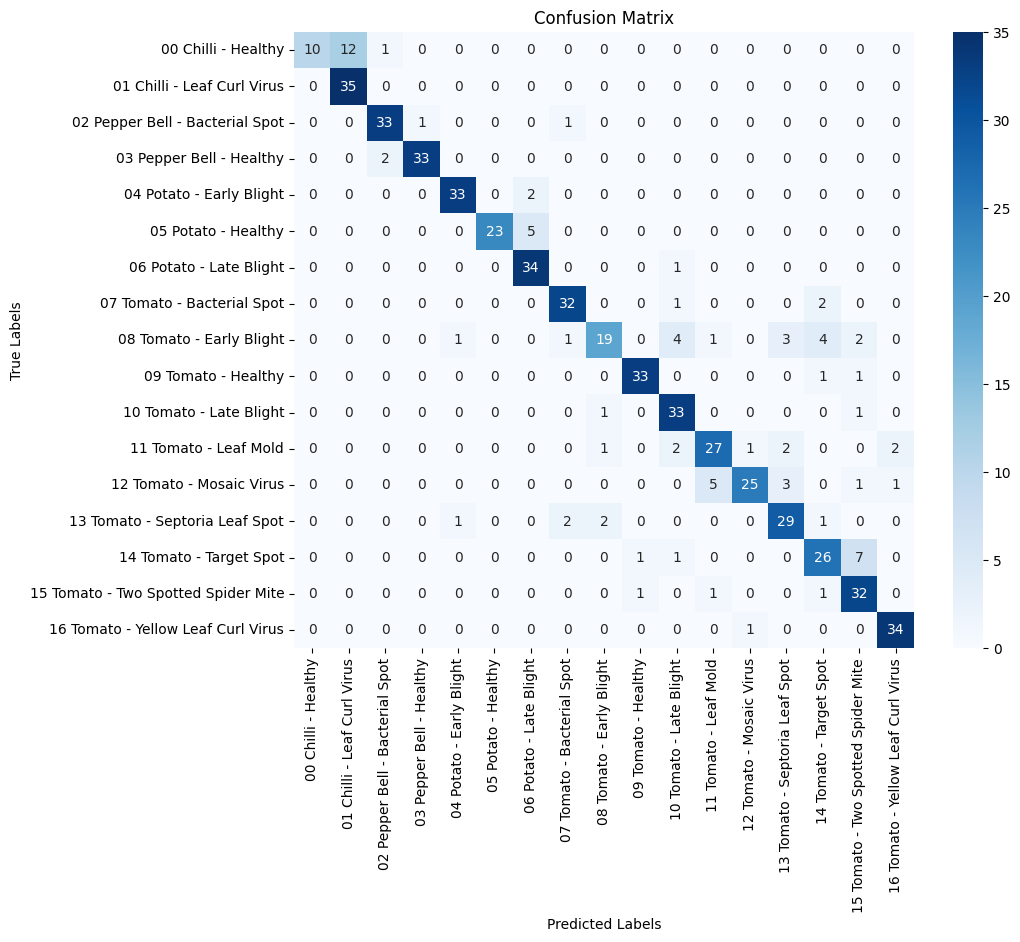

In [13]:


train_model(
    base_model_name='InceptionV3',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/test',
    model_save_name='best_inv3_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.001,
    patience=8
)

Found 20401 files belonging to 17 classes.
Using 16321 files for training.
Found 20401 files belonging to 17 classes.
Using 4080 files for validation.
Found 576 files belonging to 17 classes.
Epoch 1/40


2024-12-30 09:32:57.067454: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11986_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-30 09:32:57.461229: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11986_0', 100 bytes spill stores, 100 bytes spill loads

2024-12-30 09:32:57.542104: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11986', 204 bytes spill stores, 204 bytes spill loads

2024-12-30 09:32:57.609879: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17681', 24 bytes spill stores, 24 bytes spill loads

2024-12-30 09:32:57.676534: I external/local_xla/x

511/511 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step - accuracy: 0.4651 - loss: 1.6885 - val_accuracy: 0.8265 - val_loss: 0.5794 - learning_rate: 0.0050
Epoch 2/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.6264 - loss: 1.0521 - val_accuracy: 0.8762 - val_loss: 0.4168 - learning_rate: 0.0050
Epoch 3/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.6704 - loss: 0.9034 - val_accuracy: 0.8863 - val_loss: 0.3748 - learning_rate: 0.0050
Epoch 4/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.6770 - loss: 0.8801 - val_accuracy: 0.8686 - val_loss: 0.3742 - learning_rate: 0.0050
Epoch 5/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.6951 - loss: 0.8352 - val_accuracy: 0.8564 - val_loss: 0.4189 - learning_rate: 0.0050
Epoch 6/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.6898 - loss: 0.8591 - val_accuracy: 0.8951 - val_loss: 0.3187 - learning_rate: 0.0050
Epoch 7/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7112 - loss: 0.800

2024-12-30 09:37:39.644628: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7111 - loss: 0.7848 - val_accuracy: 0.9105 - val_loss: 0.2842 - learning_rate: 0.0050
Epoch 9/40
  3/511 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.8281 - loss: 0.6385

2024-12-30 09:38:13.709616: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7244 - loss: 0.7640 - val_accuracy: 0.9123 - val_loss: 0.2673 - learning_rate: 0.0050
Epoch 10/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7188 - loss: 0.7751 - val_accuracy: 0.8949 - val_loss: 0.3127 - learning_rate: 0.0050
Epoch 11/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7077 - loss: 0.7973 - val_accuracy: 0.8826 - val_loss: 0.3386 - learning_rate: 0.0050
Epoch 12/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.7465 - loss: 0.6847 - val_accuracy: 0.9257 - val_loss: 0.2324 - learning_rate: 0.0025
Epoch 13/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7628 - loss: 0.6431 - val_accuracy: 0.9196 - val_loss: 0.2574 - learning_rate: 0.0025
Epoch 14/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7583 - loss: 0.6553 - val_accuracy: 0.9233 - val_loss: 0.2392 - learning_rate: 0.0025
Epoch 15/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.7698 - loss: 

2024-12-30 09:42:43.300958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.7777 - loss: 0.5943 - val_accuracy: 0.9265 - val_loss: 0.2399 - learning_rate: 0.0012
Epoch 17/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7744 - loss: 0.5857 - val_accuracy: 0.9321 - val_loss: 0.2219 - learning_rate: 6.2500e-04
Epoch 18/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7891 - loss: 0.5648 - val_accuracy: 0.9314 - val_loss: 0.2262 - learning_rate: 6.2500e-04
Epoch 19/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7804 - loss: 0.5785 - val_accuracy: 0.9319 - val_loss: 0.2240 - learning_rate: 6.2500e-04
Epoch 20/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7865 - loss: 0.5659 - val_accuracy: 0.9343 - val_loss: 0.2183 - learning_rate: 3.1250e-04
Epoch 21/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7874 - loss: 0.5676 - val_accuracy: 0.9350 - val_loss: 0.2185 - learning_rate: 3.1250e-04
Epoch 22/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accur

2024-12-30 09:49:13.098253: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.7960 - loss: 0.5404 - val_accuracy: 0.9360 - val_loss: 0.2187 - learning_rate: 7.8125e-05
Epoch 29/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.7980 - loss: 0.5461 - val_accuracy: 0.9358 - val_loss: 0.2176 - learning_rate: 7.8125e-05
Epoch 30/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7932 - loss: 0.5510 - val_accuracy: 0.9365 - val_loss: 0.2175 - learning_rate: 3.9062e-05
Epoch 31/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.7980 - loss: 0.5363 - val_accuracy: 0.9373 - val_loss: 0.2179 - learning_rate: 3.9062e-05
Epoch 32/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7918 - loss: 0.5460 - val_accuracy: 0.9355 - val_loss: 0.2181 - learning_rate: 1.9531e-05
Epoch 33/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.7873 - loss: 0.5552 - val_accuracy: 0.9353 - val_loss: 0.2182 - learning_rate: 1.9531e-05


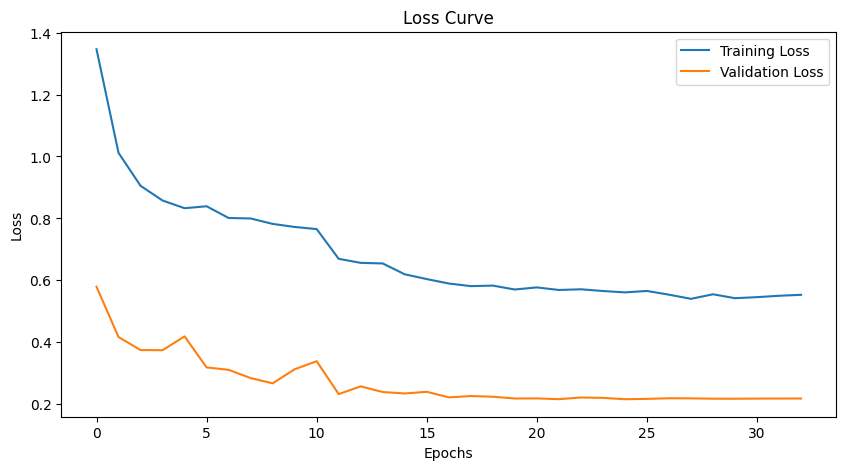

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8811 - loss: 0.3834
Test Accuracy: 86.98%
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Classification Report:
                                     precision    recall  f1-score   support

                00 Chilli - Healthy       0.00      0.00      0.00        23
        01 Chilli - Leaf Curl Virus       0.

/home/dlsathvik04/miniconda3/envs/TFG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dlsathvik04/miniconda3/envs/TFG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dlsathvik04/miniconda3/envs/TFG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

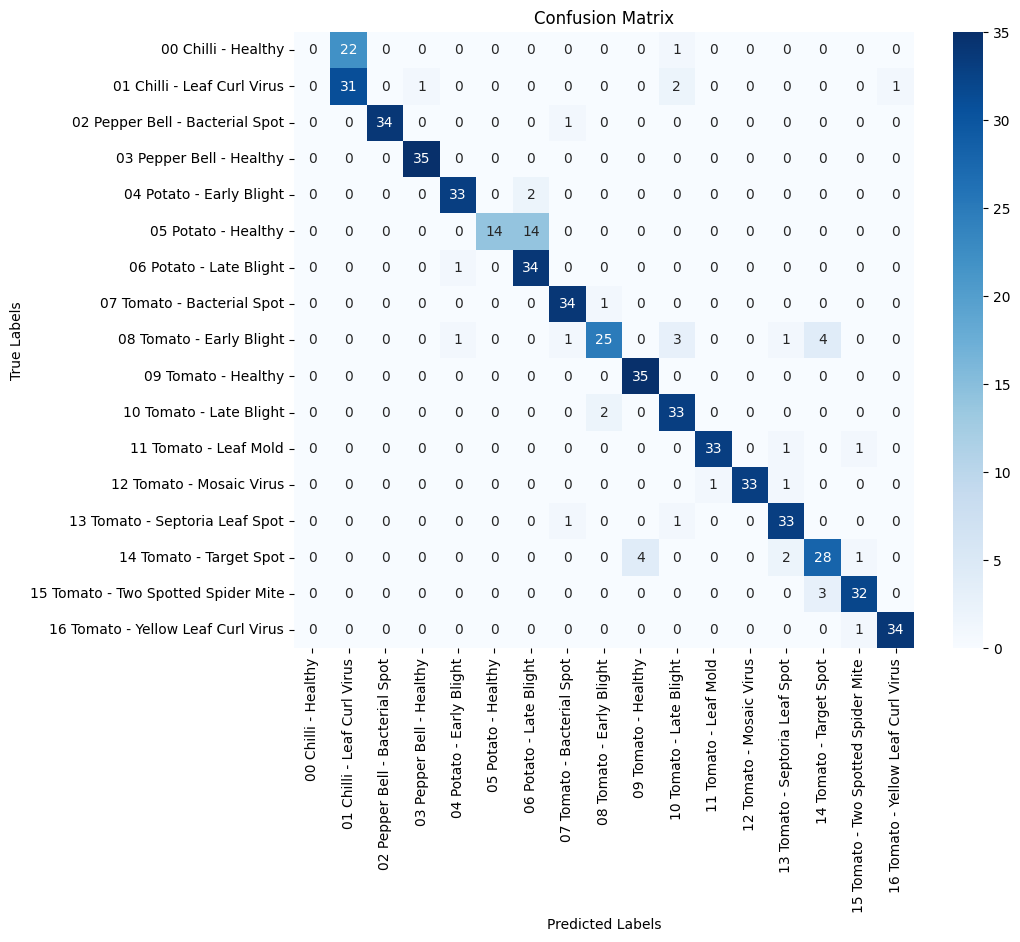

In [9]:

train_model(
    base_model_name='DenseNet121',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/test',
    model_save_name='best_dn121_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    patience=8
)